# Libs & Functions

In [5]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import soundfile as sf # writing audio files
import pandas as pd
import tensorflow as tf
from tqdm import tqdm # progress bar
import sox # trimming audio files
from sklearn.metrics import confusion_matrix
import seaborn as sn
import os
import tensorflow as tf
from tensorflow.keras import layers, models

In [2]:
def inspect_audio(audio_file: str):
    # Load audio file
    audio_file = audio_file
    y, sr = librosa.load(audio_file)
    
    # Display waveform
    plt.figure(figsize=(14, 5))
    librosa.display.waveshow(y, sr=sr)
    plt.title('Waveform')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.show()
    
    # Mel spectrogram
    S = librosa.feature.melspectrogram(y=y, sr=sr)
    S_db = librosa.power_to_db(S, ref=np.max)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel spectrogram')
    plt.show()
    
    # tempo and beat frames
    tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)
    print(f"Estimated tempo: {tempo} BPM")
    print(f"Beat frames: {beat_frames}")

In [4]:
# list all files in a directory
def list_files(directory):
    file_list = []
    if os.path.exists(directory) and os.path.isdir(directory):
        files = os.listdir(directory)
        if files:
            print(f"Files in directory '{directory}':")
            for file in files:
                print(file)
                file_list.append(file)
            return file_list

        else:
            print(f"No files found in directory '{directory}'")
    else:
        print(f"Directory '{directory}' does not exist or is not a valid directory.")

# Data

## Download data

In [2]:
%%sh
scdl -l https://soundcloud.com/nasa/sets/solar-system-beyond-sounds

In [ ]:
! scdl -l https://soundcloud.com/nasa/sets/spookyspacesounds

## Inspect Data

In [6]:
# list files
directory_path = './data/raw/Solar System & Beyond Sounds/'
file_list = list_files(directory_path)

Files in directory './data/raw/Solar System & Beyond Sounds/':
Solar System & Beyond Sounds_Audio of Juno’s Ganymede Flyby.wav
Solar System & Beyond Sounds_Cassini Enceladus Sound.mp3
Solar System & Beyond Sounds_Cassini Saturn Radio Emissions #1.mp3
Solar System & Beyond Sounds_Cassini Saturn Radio Emissions #2.mp3
Solar System & Beyond Sounds_Chorus Radio Waves within Earth's Atmosphere.mp3
Solar System & Beyond Sounds_First Likely Marsquake Heard by NASA's InSight.mp3
Solar System & Beyond Sounds_Juno Morse code HI received from Earth.mp3
Solar System & Beyond Sounds_Kepler Star KIC12268220C Light Curve Waves to Sound.mp3
Solar System & Beyond Sounds_Kepler Star KIC7671081B Light Curve Waves to Sound.mp3
Solar System & Beyond Sounds_LCROSS Water on the Moon Song.mp3
Solar System & Beyond Sounds_Parker Solar Probe - Langmuir Waves.mp3
Solar System & Beyond Sounds_Parker Solar Probe - Whistler Mode Waves 1.mp3
Solar System & Beyond Sounds_Parker Solar Probe - Whistler Mode Waves 2.mp3

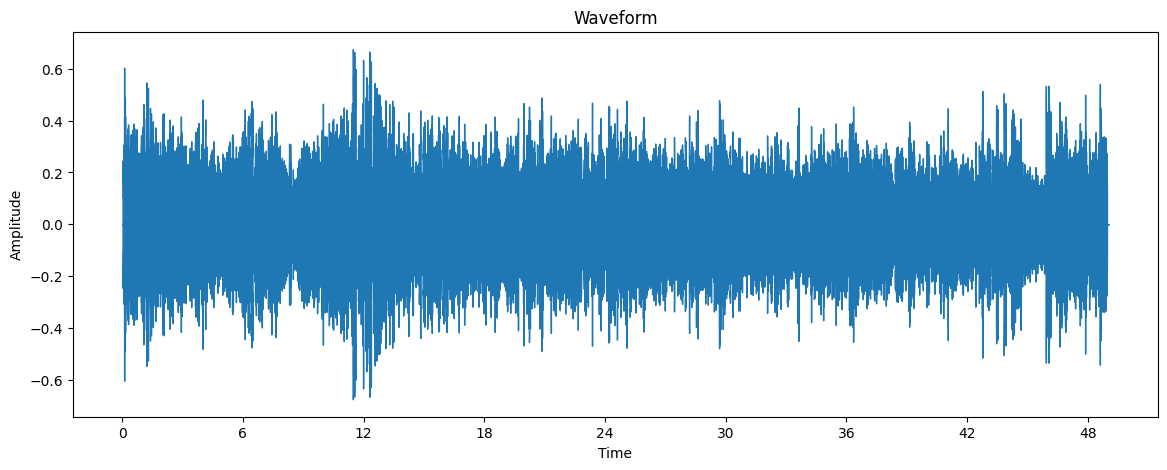

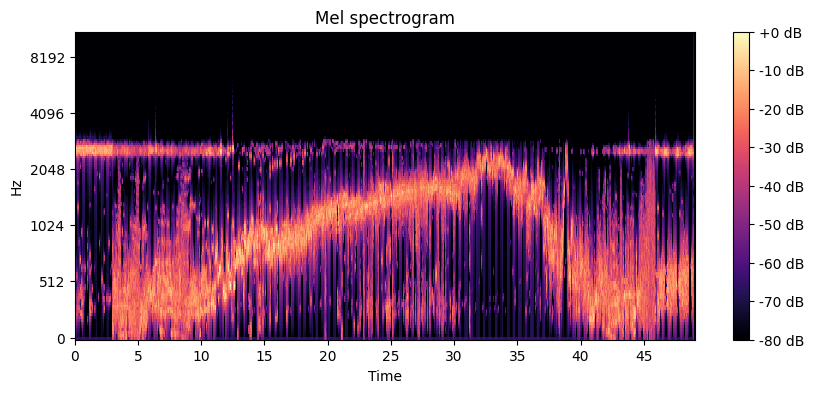

Estimated tempo: 161.4990234375 BPM
Beat frames: [   3   19   35   52   68   84  101  117  133  149  165  181  196  212
  228  244  260  276  291  306  321  337  353  369  385  401  417  433
  449  465  481  497  511  526  542  556  571  588  603  619  634  649
  665  682  698  714  731  747  763  779  796  812  828  845  861  878
  894  910  927  943  959  975  992 1008 1025 1041 1058 1076 1093 1110
 1127 1143 1160 1176 1192 1209 1225 1240 1255 1271 1287 1303 1320 1336
 1353 1369 1385 1402 1418 1434 1451 1467 1483 1500 1516 1532 1548 1565
 1581 1598 1614 1630 1646 1662 1679 1696 1712 1728 1744 1761 1778 1794
 1810 1826 1842 1859 1876 1893 1909 1925 1940 1955 1970 1986 2000 2015
 2030 2045 2060 2076 2093]


In [10]:
inspect_audio(directory_path + "/Solar System & Beyond Sounds_Audio of Juno’s Ganymede Flyby.wav")

# Agenda

+ inspect audio
+ normalization
+ labeling
+ audio augmentation

## 1. Inspect Audio

### Waveform

In [8]:
file_list[0]

'Solar System & Beyond Sounds_Audio of Juno’s Ganymede Flyby.wav'

In [9]:
y, sr = librosa.load(directory_path + file_list[0])

In [10]:
print(y) # numpy array -> audio time series (amplitude)
print(sr) # sample rate

[-1.0286316e-04  4.6032746e-05  5.1950003e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00]
22050


/home/naska/miniconda3/envs/Vision/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/naska/miniconda3/envs/Vision/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/naska/miniconda3/envs/Vision/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/naska/miniconda3/envs/Vision/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed

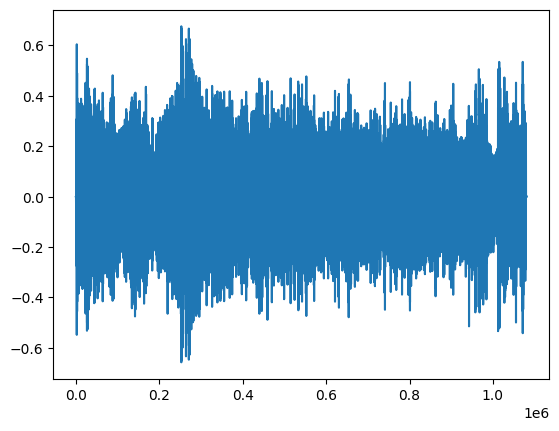

In [11]:
sns.lineplot(data=y)
plt.show()

/home/naska/miniconda3/envs/Vision/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/naska/miniconda3/envs/Vision/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/naska/miniconda3/envs/Vision/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/naska/miniconda3/envs/Vision/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed

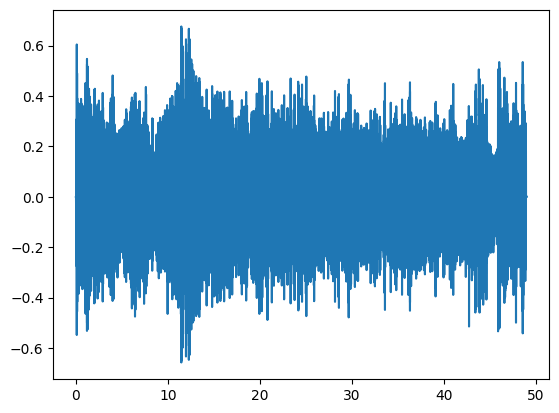

In [29]:
t = np.linspace(0, y.shape[0] / sr, y.shape[0])
sns.lineplot(y=y, x = t)
plt.show()

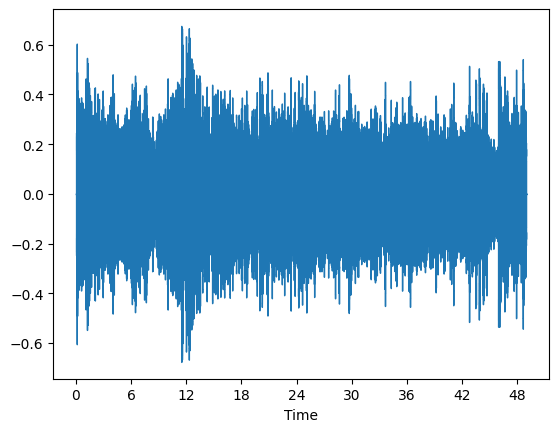

In [31]:
# in alternativa
librosa.display.waveshow(y, sr=sr)
plt.show()

### Mel Spectrogram
see insepct_audio() function

### Sampling Rate

In [12]:
# Controllo se è uguale per tutti i file
sr_set = set()
for file in file_list:
    y, sr = librosa.load(directory_path + file)
    print("Checking file: ", file)
    sr_set.add(sr)
print(sr_set)

Checking file:  Solar System & Beyond Sounds_Audio of Juno’s Ganymede Flyby.wav
Checking file:  Solar System & Beyond Sounds_Cassini Enceladus Sound.mp3
Checking file:  Solar System & Beyond Sounds_Cassini Saturn Radio Emissions #1.mp3
Checking file:  Solar System & Beyond Sounds_Cassini Saturn Radio Emissions #2.mp3
Checking file:  Solar System & Beyond Sounds_Chorus Radio Waves within Earth's Atmosphere.mp3
Checking file:  Solar System & Beyond Sounds_First Likely Marsquake Heard by NASA's InSight.mp3
Checking file:  Solar System & Beyond Sounds_Juno Morse code HI received from Earth.mp3
Checking file:  Solar System & Beyond Sounds_Kepler Star KIC12268220C Light Curve Waves to Sound.mp3
Checking file:  Solar System & Beyond Sounds_Kepler Star KIC7671081B Light Curve Waves to Sound.mp3
Checking file:  Solar System & Beyond Sounds_LCROSS Water on the Moon Song.mp3
Checking file:  Solar System & Beyond Sounds_Parker Solar Probe - Langmuir Waves.mp3
Checking file:  Solar System & Beyond 

### Amplitude

In [13]:
# Controllo intervalli ampiezze
def amplitudes_ranges(directory_path: str, file_list: list()):
    for file in file_list:
        y, sr = librosa.load(directory_path + file)
        print("Amplitudes")
        print("Min: ", np.min(y), "Max:", np.max(y))

amplitudes_ranges(directory_path, file_list)

Amplitudes
Min:  -0.65777946 Max: 0.67573774
Amplitudes
Min:  -0.97269523 Max: 0.9688127
Amplitudes
Min:  -0.7001455 Max: 0.6227772
Amplitudes
Min:  -0.38694796 Max: 0.3718655
Amplitudes
Min:  -0.7085043 Max: 0.70935476
Amplitudes
Min:  -0.4117077 Max: 0.41404846
Amplitudes
Min:  -0.8279297 Max: 0.87160337
Amplitudes
Min:  -1.0886098 Max: 0.49986833
Amplitudes
Min:  -0.5601425 Max: 1.4127476
Amplitudes
Min:  -0.9654207 Max: 0.9736781
Amplitudes
Min:  -0.52321076 Max: 0.5203973
Amplitudes
Min:  -0.5373094 Max: 0.52820027
Amplitudes
Min:  -0.5312934 Max: 0.5354819
Amplitudes
Min:  -0.8735425 Max: 0.81326175
Amplitudes
Min:  -0.59181273 Max: 0.5856643
Amplitudes
Min:  -0.6734662 Max: 0.5742168
Amplitudes
Min:  -0.54884386 Max: 0.54153
Amplitudes
Min:  -0.60445696 Max: 0.68773776
Amplitudes
Min:  -0.68368465 Max: 0.6866571
Amplitudes
Min:  -0.3712194 Max: 0.31194177
Amplitudes
Min:  -0.8173826 Max: 0.81905454
Amplitudes
Min:  -0.48754308 Max: 0.40658382
Amplitudes
Min:  -0.976678 Max: 0.97

**Nota**
Gli intervalli sono quasi tutti in (-1, 1), tuttavia almeno un file va oltre l'intervallo -> normalizzazione

## 2. Normalize

In [14]:
def normalize_audio(directory_path: str, file_list: list(), output_dir: str):
    for file in file_list:
        print(file)
        y, sr = librosa.load(directory_path + file)
        normalized_audio = librosa.util.normalize(y, norm=2) # options: norm = None or norm = 2
        # also see: subtype='PCM_24
        sf.write(file = output_dir + file, data = normalized_audio, samplerate = sr)

In [15]:
directory_path = './data/raw/Solar System & Beyond Sounds/'
normalize_audio(directory_path, file_list, "./data/normalized/")

Solar System & Beyond Sounds_Audio of Juno’s Ganymede Flyby.wav
Solar System & Beyond Sounds_Cassini Enceladus Sound.mp3
Solar System & Beyond Sounds_Cassini Saturn Radio Emissions #1.mp3
Solar System & Beyond Sounds_Cassini Saturn Radio Emissions #2.mp3
Solar System & Beyond Sounds_Chorus Radio Waves within Earth's Atmosphere.mp3
Solar System & Beyond Sounds_First Likely Marsquake Heard by NASA's InSight.mp3
Solar System & Beyond Sounds_Juno Morse code HI received from Earth.mp3
Solar System & Beyond Sounds_Kepler Star KIC12268220C Light Curve Waves to Sound.mp3
Solar System & Beyond Sounds_Kepler Star KIC7671081B Light Curve Waves to Sound.mp3
Solar System & Beyond Sounds_LCROSS Water on the Moon Song.mp3
Solar System & Beyond Sounds_Parker Solar Probe - Langmuir Waves.mp3
Solar System & Beyond Sounds_Parker Solar Probe - Whistler Mode Waves 1.mp3
Solar System & Beyond Sounds_Parker Solar Probe - Whistler Mode Waves 2.mp3
Solar System & Beyond Sounds_Plasmaspheric Hiss.wav
Solar Syst

In [16]:
amplitudes_ranges('./data/normalized/', file_list)

Amplitudes
Min:  -0.006164551 Max: 0.0063171387
Amplitudes
Min:  -0.005912952 Max: 0.006126741
Amplitudes
Min:  -0.009393388 Max: 0.00908233
Amplitudes
Min:  -0.010147548 Max: 0.00985348
Amplitudes
Min:  -0.019793054 Max: 0.019995522
Amplitudes
Min:  -0.017921727 Max: 0.017994571
Amplitudes
Min:  -0.03870695 Max: 0.040271904
Amplitudes
Min:  -0.011644944 Max: 0.0052584377
Amplitudes
Min:  -0.0024987783 Max: 0.0063206316
Amplitudes
Min:  -0.0052271467 Max: 0.0053208573
Amplitudes
Min:  -0.011413166 Max: 0.011329713
Amplitudes
Min:  -0.0069421963 Max: 0.007019925
Amplitudes
Min:  -0.007962296 Max: 0.008563047
Amplitudes
Min:  -0.010925293 Max: 0.010131836
Amplitudes
Min:  -0.027686553 Max: 0.027466683
Amplitudes
Min:  -0.011103033 Max: 0.0095011145
Amplitudes
Min:  -0.00933473 Max: 0.009233058
Amplitudes
Min:  -0.008880982 Max: 0.01011568
Amplitudes
Min:  -0.021095674 Max: 0.021150386
Amplitudes
Min:  -0.008896926 Max: 0.0074344864
Amplitudes
Min:  -0.014207105 Max: 0.013945542
Amplitude

## 3. Split & Labeling

In [14]:
# label mapping for audio files (original list)
label_mapping = {
    'Solar System & Beyond Sounds_Audio of Juno’s Ganymede Flyby.wav': 'Spacecraft Signals',
    'Solar System & Beyond Sounds_Cassini Enceladus Sound.mp3': 'Planetary Sounds',
    'Solar System & Beyond Sounds_Cassini Saturn Radio Emissions #1.mp3': 'Planetary Sounds',
    'Solar System & Beyond Sounds_Cassini Saturn Radio Emissions #2.mp3': 'Planetary Sounds',
    'Solar System & Beyond Sounds_Chorus Radio Waves within Earth\'s Atmosphere.mp3': 'Earth\'s Magnetosphere',
    'Solar System & Beyond Sounds_First Likely Marsquake Heard by NASA\'s InSight.mp3': 'Planetary Sounds',
    'Solar System & Beyond Sounds_Juno Morse code HI received from Earth.mp3': 'Spacecraft Signals',
    'Solar System & Beyond Sounds_Kepler Star KIC12268220C Light Curve Waves to Sound.mp3': 'Cosmic Phenomena',
    'Solar System & Beyond Sounds_Kepler Star KIC7671081B Light Curve Waves to Sound.mp3': 'Cosmic Phenomena',
    'Solar System & Beyond Sounds_LCROSS Water on the Moon Song.mp3': 'Planetary Sounds',
    'Solar System & Beyond Sounds_Parker Solar Probe - Langmuir Waves.mp3': 'Spacecraft Signals',
    'Solar System & Beyond Sounds_Parker Solar Probe - Whistler Mode Waves 1.mp3': 'Spacecraft Signals',
    'Solar System & Beyond Sounds_Parker Solar Probe - Whistler Mode Waves 2.mp3': 'Spacecraft Signals',
    'Solar System & Beyond Sounds_Plasmaspheric Hiss.wav': 'Cosmic Phenomena',
    'Solar System & Beyond Sounds_Plasmawaves - Chorus.mp3': 'Earth\'s Magnetosphere',
    'Solar System & Beyond Sounds_Quindar Sound #1.mp3': 'Spacecraft Signals',
    'Solar System & Beyond Sounds_Quindar Sound #2.mp3': 'Spacecraft Signals',
    'Solar System & Beyond Sounds_Sonification of a Hubble Deep Space Image.mp3': 'Cosmic Phenomena',
    'Solar System & Beyond Sounds_Sounds of Earth\'s Magnetic Drum in Space.mp3': 'Earth\'s Magnetosphere',
    'Solar System & Beyond Sounds_Sounds of Saturn Hear Radio Emissions of the Planet and Its Moon Enceladus.mp3': 'Planetary Sounds',
    'Solar System & Beyond Sounds_Sputnik Beep.mp3': 'Spacecraft Signals',
    'Solar System & Beyond Sounds_Stardust Passing Comet Tempel 1.mp3': 'Planetary Sounds',
    'Solar System & Beyond Sounds_Sun Sonification.wav': 'Cosmic Phenomena',
    'Solar System & Beyond Sounds_Voyager 1 Three Tsunami Waves in Interstellar Space.mp3': 'Cosmic Phenomena',
    'Solar System & Beyond Sounds_Voyager Interstellar Plasma Sounds.mp3': 'Spacecraft Signals',
    'Solar System & Beyond Sounds_Voyager Lightning on Jupiter.mp3': 'Planetary Sounds',
    'Solar System & Beyond Sounds_Whistler Waves.mp3': 'Cosmic Phenomena'
}

In [8]:
df = pd.DataFrame(data = label_mapping.items(), columns = ["file", "label"])
df["label"].value_counts()

label
Spacecraft Signals       9
Planetary Sounds         8
Cosmic Phenomena         7
Earth's Magnetosphere    3
Name: count, dtype: int64

In [29]:
def split_audio(file_list):
    directory_path = './data/raw/Solar System & Beyond Sounds/'
    output_path = './data/trimmed/'
    for file in file_list:
        print("Splitting: ", file)
        file_path = directory_path + file
        sample_rate = sox.file_info.sample_rate(file_path)
        n_samples = sox.file_info.num_samples(file_path)
        # how many splits?
        n_split = int(n_samples / sample_rate)
        print("Number of splits: ", n_split)
        #for i in tqdm(range(0, n_samples, n_split)): # more than 48k files for first audio! (too much time)
        for i in range(0, n_split):
            tfm = sox.Transformer()
            # trim the audio between every n_split seconds.
            tfm.trim(i, i+sample_rate)
            # attach label to file
            label = label_mapping.get(file)
            if label:
                output_file = output_path + str(i) + "_" + label + "_" + file
                tfm.build_file(file_path, output_file)
                print("Wrote: ", output_file)
            else:
                print("Label not found.")

split_audio(file_list) # generates 578 files

Splitting:  Solar System & Beyond Sounds_Audio of Juno’s Ganymede Flyby.wav
Number of splits:  49
Wrote:  ./data/trimmed/0_Spacecraft Signals_Solar System & Beyond Sounds_Audio of Juno’s Ganymede Flyby.wav
Wrote:  ./data/trimmed/1_Spacecraft Signals_Solar System & Beyond Sounds_Audio of Juno’s Ganymede Flyby.wav
Wrote:  ./data/trimmed/2_Spacecraft Signals_Solar System & Beyond Sounds_Audio of Juno’s Ganymede Flyby.wav
Wrote:  ./data/trimmed/3_Spacecraft Signals_Solar System & Beyond Sounds_Audio of Juno’s Ganymede Flyby.wav
Wrote:  ./data/trimmed/4_Spacecraft Signals_Solar System & Beyond Sounds_Audio of Juno’s Ganymede Flyby.wav
Wrote:  ./data/trimmed/5_Spacecraft Signals_Solar System & Beyond Sounds_Audio of Juno’s Ganymede Flyby.wav
Wrote:  ./data/trimmed/6_Spacecraft Signals_Solar System & Beyond Sounds_Audio of Juno’s Ganymede Flyby.wav
Wrote:  ./data/trimmed/7_Spacecraft Signals_Solar System & Beyond Sounds_Audio of Juno’s Ganymede Flyby.wav
Wrote:  ./data/trimmed/8_Spacecraft Si

## Dataset

In [42]:
# load audio, compute Mel spectrogram, and generate features and labels
def load_and_process_audio(audio_file, label, max_length):
    directory_path = './data/trimmed/'
    y, sr = librosa.load(directory_path + audio_file)
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)  # Convert to dB scale

    # pad or trim spectrogram to a fixed length (features must have equal size)
    if mel_spectrogram_db.shape[1] < max_length:
        pad_width = max_length - mel_spectrogram_db.shape[1]
        mel_spectrogram_db = np.pad(mel_spectrogram_db, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mel_spectrogram_db = mel_spectrogram_db[:, :max_length]

    return mel_spectrogram_db, label

In [ ]:
# audio file complete paths
directory_path = './data/trimmed/'
#audio_files = [directory_path + file for file in file_list]
audio_files = list_files(directory_path)

In [ ]:
# create TensorFlow dataset
spectrograms = []
labels = []

for audio_file in tqdm(audio_files):
    label = audio_file.split("_")[1]
    if label:
        max_length = 256 # first spectrogram.shape[1]
        spectrogram, label = load_and_process_audio(audio_file, label, max_length)
        print(spectrogram.shape)
        spectrograms.append(spectrogram)
        labels.append(label)

In [47]:
spectrograms[0].shape

(128, 256)

In [70]:
# lists to TensorFlow tensors
spectrograms = np.array(spectrograms)
labels = np.array(labels)

# convert labels to numerical IDs (if not already done)
label_to_id = {label: i for i, label in enumerate(set(labels))}
numeric_labels = [label_to_id[label] for label in labels]
# convert numeric labels to one-hot encoded representations
one_hot_labels = tf.one_hot(numeric_labels, depth=len(set(labels)))

# TensorFlow dataset from tensors
dataset = tf.data.Dataset.from_tensor_slices((spectrograms, one_hot_labels))

In [71]:
# Dataset Split

# training, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size).take(val_size)
test_dataset = dataset.skip(train_size + val_size)

# shuffle and batch the datasets
batch_size = 16
train_dataset = train_dataset.shuffle(buffer_size=train_size).batch(batch_size, drop_remainder=True)
val_dataset = val_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

### Inspect

In [72]:
for spectrogram, label in train_dataset.take(3):
    print(f"Spectrogram shape: {spectrogram.shape}, Label: {label}")

Spectrogram shape: (16, 128, 256), Label: [[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]]
Spectrogram shape: (16, 128, 256), Label: [[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]]
Spectrogram shape: (16, 128, 256), Label: [[0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]]
Spectrogram shape: (16, 128, 256), Label: [[0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0.

In [73]:
# information about dataset elements
print(dataset.element_spec)

(TensorSpec(shape=(128, 256), dtype=tf.float32, name=None), TensorSpec(shape=(4,), dtype=tf.float32, name=None))


In [74]:
spectrogram.shape

TensorShape([16, 128, 256])

## Model

In [75]:
num_classes = 4

# CNN
model = models.Sequential([
    layers.Input(shape=(spectrogram.shape[1], spectrogram.shape[2], 1) ),  # input shape based on the spectrogram dimensions
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'), 
    layers.MaxPooling2D((2, 2), padding ='same'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), padding ='same'),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [76]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 128, 256, 32)      320       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 64, 128, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 128, 64)       18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 32, 64, 64)        0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 131072)            0         
                                                                 
 dense_6 (Dense)             (None, 128)              

In [77]:
from tensorflow.keras.losses import CategoricalCrossentropy

In [82]:
# Compile
model.compile(optimizer='adam',
              loss=CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train
history = model.fit(train_dataset, epochs=5, initial_epoch=0, validation_data=val_dataset)

Epoch 1/5
25/25 [==============================] - 15s 525ms/step - loss: 0.2998 - accuracy: 0.9400 - val_loss: 1.1694 - val_accuracy: 0.8023
Epoch 2/5
25/25 [==============================] - 13s 518ms/step - loss: 0.0259 - accuracy: 0.9925 - val_loss: 1.0042 - val_accuracy: 0.8372
Epoch 3/5
25/25 [==============================] - 13s 542ms/step - loss: 0.0318 - accuracy: 0.9925 - val_loss: 0.6108 - val_accuracy: 0.8721
Epoch 4/5
25/25 [==============================] - 14s 544ms/step - loss: 0.0201 - accuracy: 0.9975 - val_loss: 0.6244 - val_accuracy: 0.8953
Epoch 5/5
25/25 [==============================] - 13s 531ms/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.6964 - val_accuracy: 0.8488


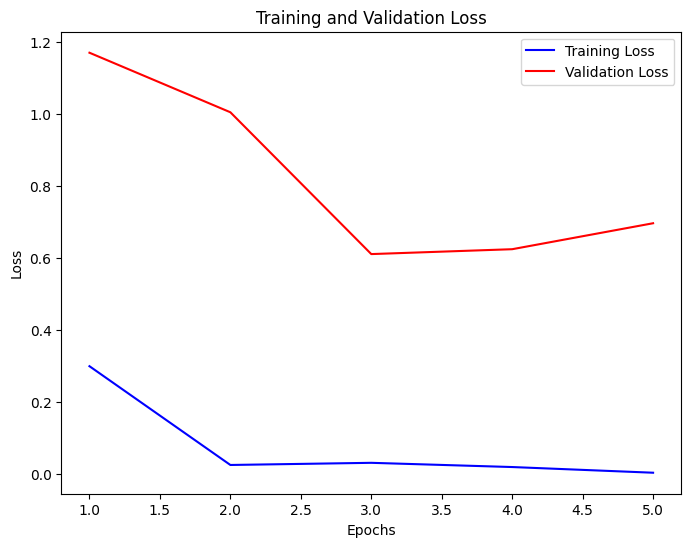

In [83]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

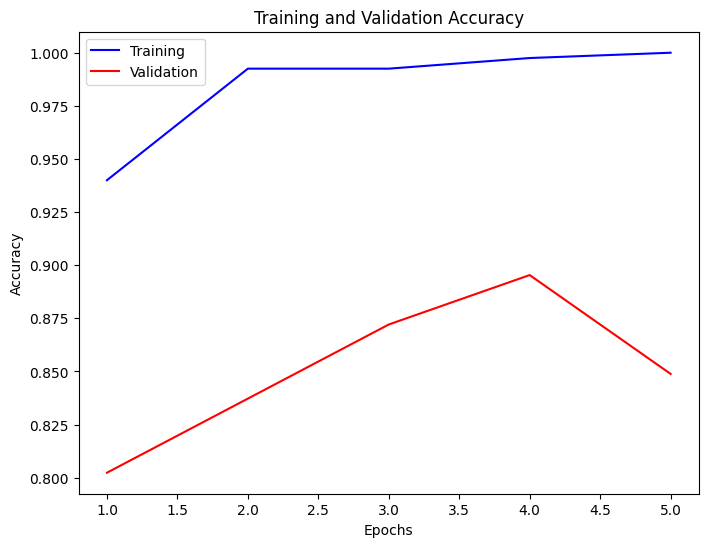

In [85]:
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, history.history["accuracy"], 'b', label='Training')
plt.plot(epochs, history.history["val_accuracy"], 'r', label='Validation')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

6/6 [==============================] - 1s 102ms/step


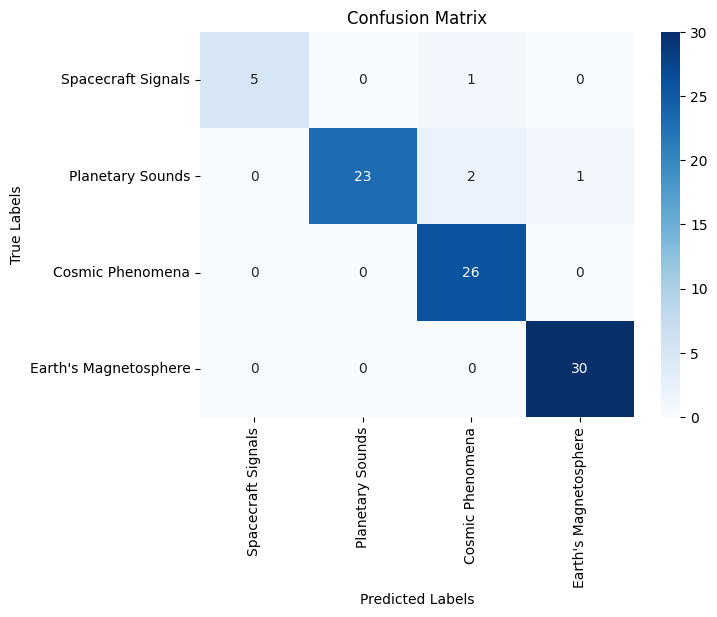

In [90]:
# confusion matrix
predictions = model.predict(test_dataset)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.concatenate([y for x, y in test_dataset], axis=0)


# true_labels and predicted_labels to class indices
true_labels = np.argmax(true_labels, axis=1)
predicted_labels = np.argmax(predictions, axis=1)

conf_matrix = confusion_matrix(true_labels, predicted_labels)
class_names = ["Spacecraft Signals","Planetary Sounds", "Cosmic Phenomena", "Earth's Magnetosphere"]

plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [88]:
for spectrogram, label in train_dataset.take(3):  # Take a batch from the dataset
    predictions = model.predict(spectrogram)  # Get model predictions for the batch
    print(f"Logits shape: {predictions.shape}, Labels shape: {label.shape}")

1/1 [==============================] - 0s 260ms/step
Logits shape: (16, 4), Labels shape: (16, 4)
1/1 [==============================] - 0s 149ms/step
Logits shape: (16, 4), Labels shape: (16, 4)
1/1 [==============================] - 0s 133ms/step
Logits shape: (16, 4), Labels shape: (16, 4)


In [80]:
model.evaluate(test_dataset)

6/6 [==============================] - 1s 75ms/step - loss: 0.0872 - accuracy: 0.9659


[0.08724610507488251, 0.9659090638160706]

In [93]:
val_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 128, 256), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>